Using device: cuda
Processing example image: pictures/15-4-20\IMG_0869.JPG
Enhancing image: pictures/15-4-20\IMG_0869.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0
Enhancing image: pictures/15-4-20\IMG_0869.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 725.47it/s]


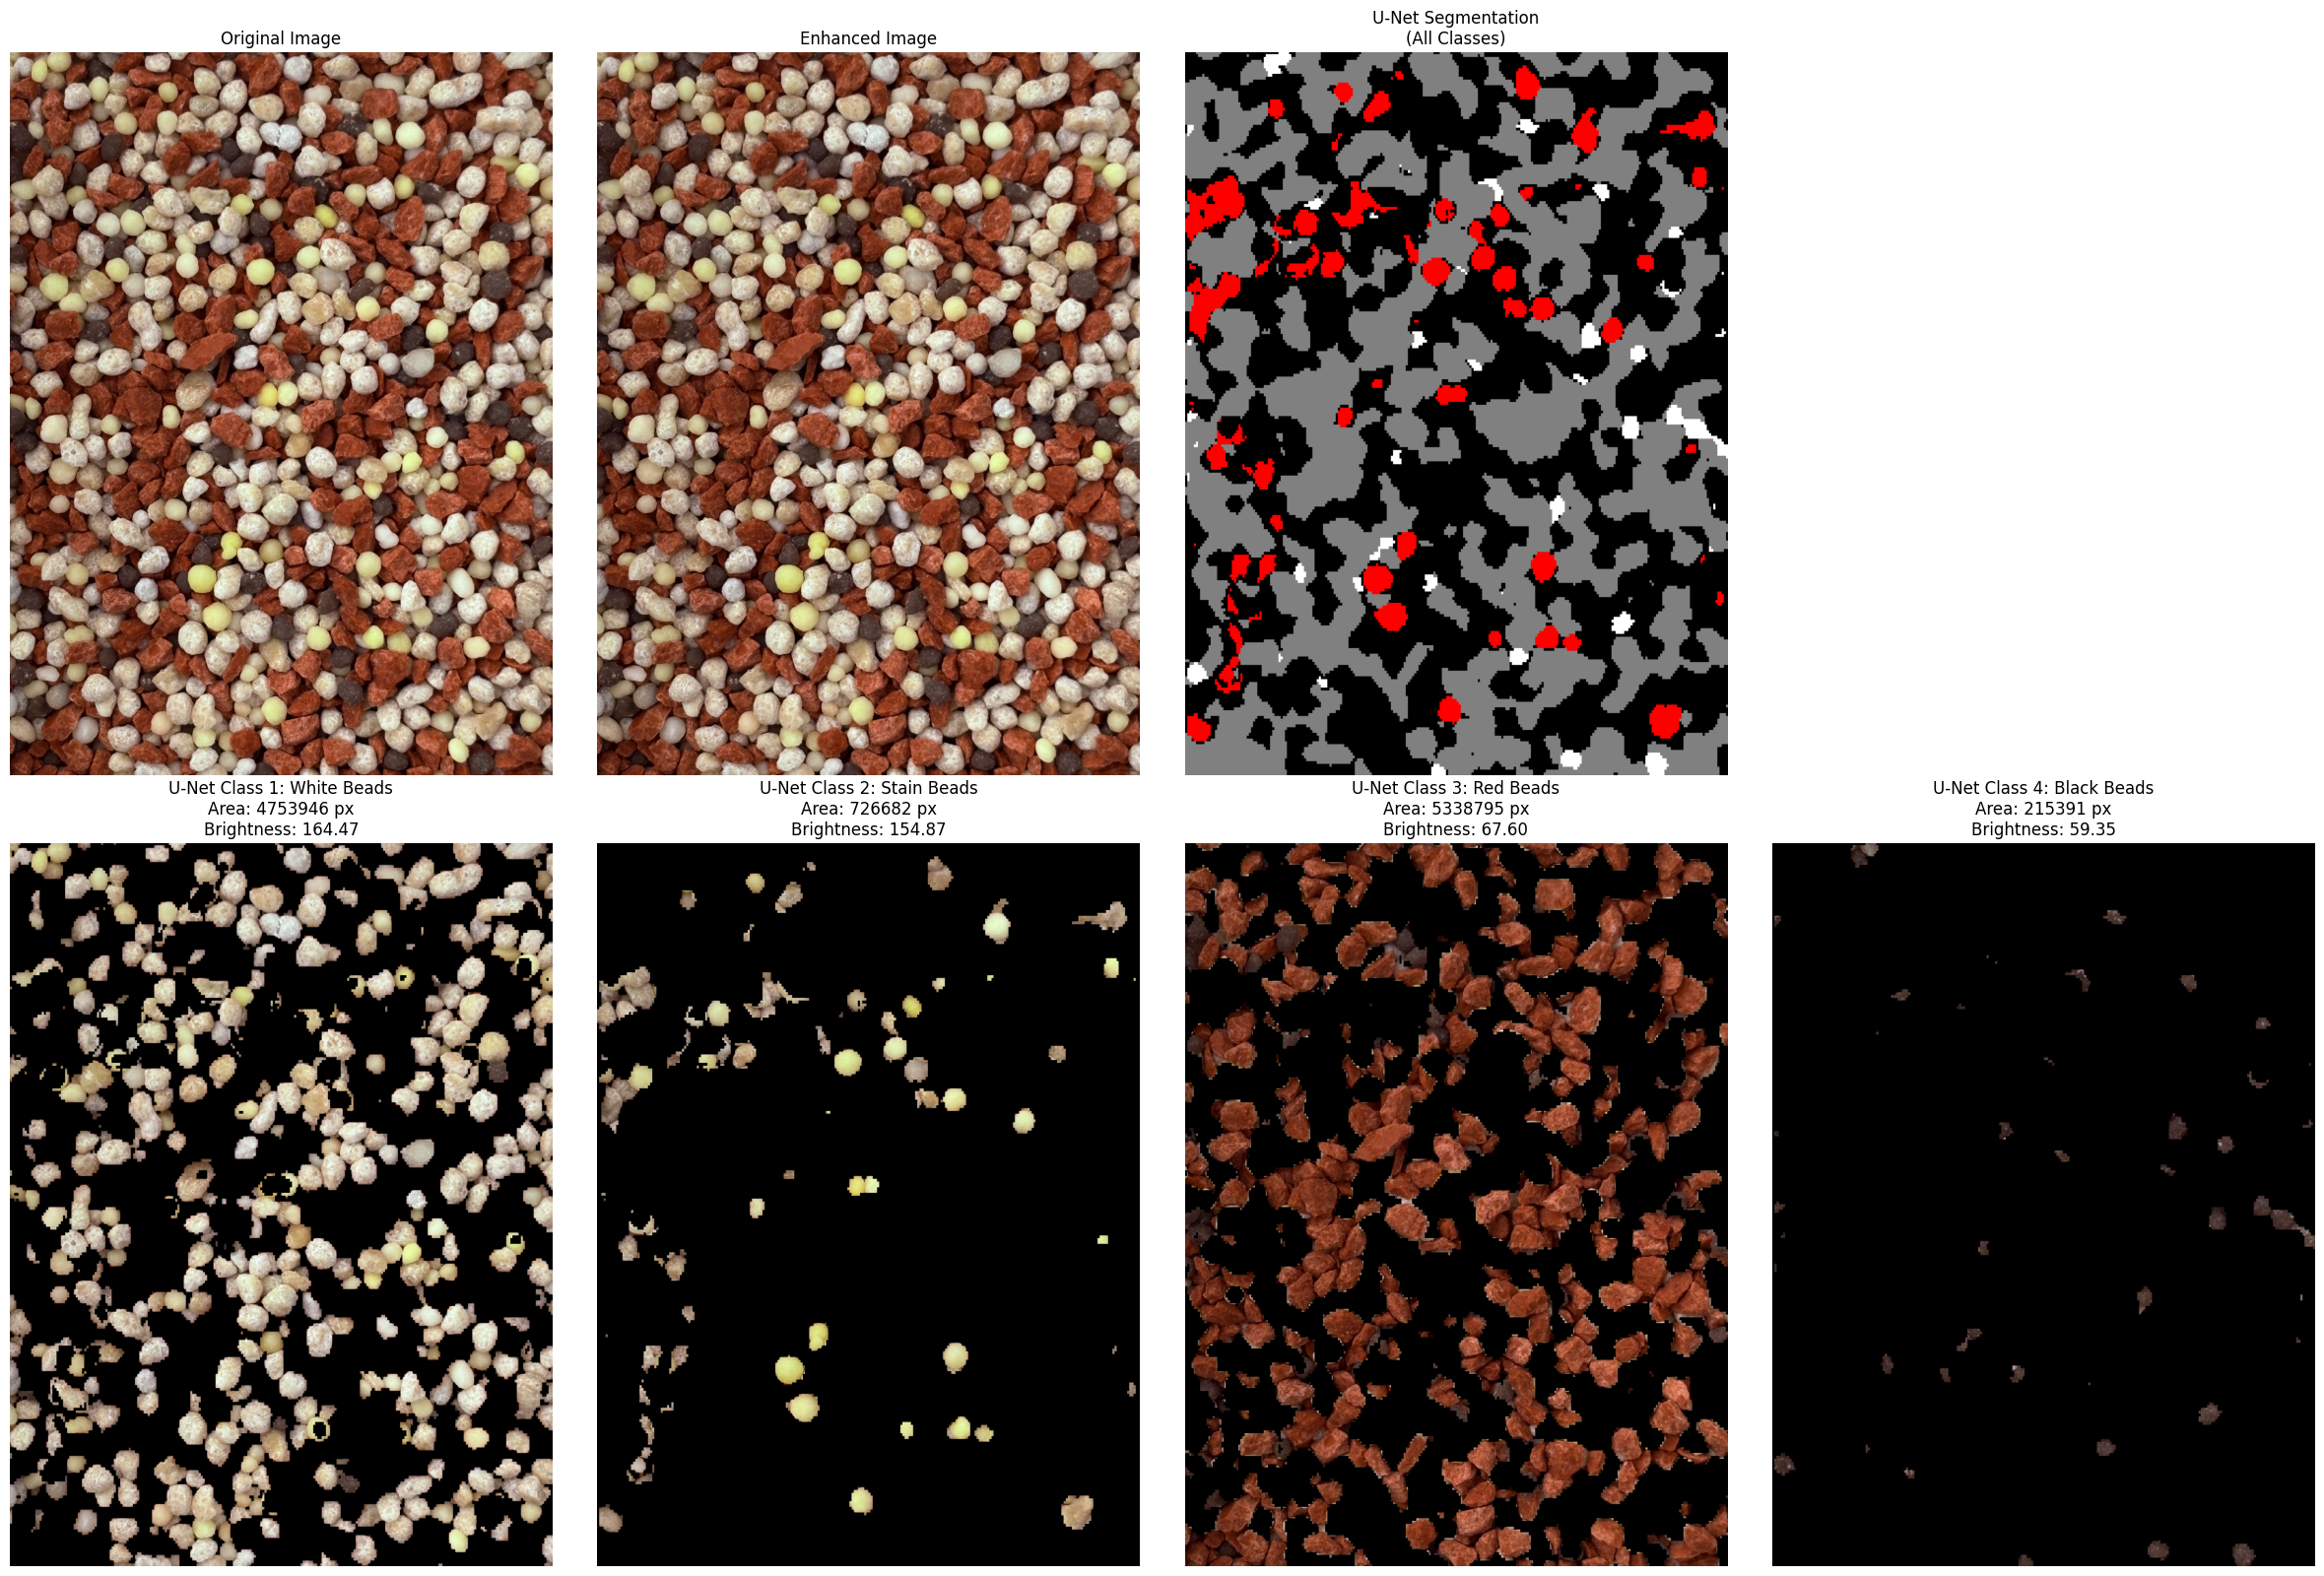


U-Net Prediction Statistics:
----------------------------------------
Background: 1157954 pixels
Class 1 (White Beads): 215391 pixels
Class 2 (Stain Beads): 5338795 pixels
Class 3 (Red Beads): 726682 pixels
Class 4 (Black Beads): 4753946 pixels

U-Net Cluster Statistics:
------------------------------
White Beads: 4753946 pixels
Stain Beads: 726682 pixels
Red Beads: 5338795 pixels
Black Beads: 215391 pixels

Processing all images to get cluster areas...
Processing 69 images using GPU U-Net

Folder 1: Processing 23 images
----------------------------------------

[1/69] Processing: IMG_0869.JPG
Enhancing image: pictures/15-4-20\IMG_0869.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 999.89it/s]



[2/69] Processing: IMG_0870.JPG
Enhancing image: pictures/15-4-20\IMG_0870.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 1141.70it/s]



[3/69] Processing: IMG_0871.JPG
Enhancing image: pictures/15-4-20\IMG_0871.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 999.24it/s]



[4/69] Processing: IMG_0872.JPG
Enhancing image: pictures/15-4-20\IMG_0872.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 887.73it/s]



[5/69] Processing: IMG_0873.JPG
Enhancing image: pictures/15-4-20\IMG_0873.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 1000.31it/s]



[6/69] Processing: IMG_0874.JPG
Enhancing image: pictures/15-4-20\IMG_0874.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 886.42it/s]



[7/69] Processing: IMG_0890.JPG
Enhancing image: pictures/15-4-20\IMG_0890.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 994.09it/s]



[8/69] Processing: IMG_0891.JPG
Enhancing image: pictures/15-4-20\IMG_0891.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 963.82it/s]



[9/69] Processing: IMG_0892.JPG
Enhancing image: pictures/15-4-20\IMG_0892.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 999.95it/s]



[10/69] Processing: IMG_0893.JPG
Enhancing image: pictures/15-4-20\IMG_0893.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 799.37it/s]



[11/69] Processing: IMG_0894.JPG
Enhancing image: pictures/15-4-20\IMG_0894.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 800.13it/s]



[12/69] Processing: IMG_0937.JPG
Enhancing image: pictures/15-4-20\IMG_0937.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 799.30it/s]



[13/69] Processing: IMG_0938.JPG
Enhancing image: pictures/15-4-20\IMG_0938.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 801.36it/s]



[14/69] Processing: IMG_0939.JPG
Enhancing image: pictures/15-4-20\IMG_0939.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 614.01it/s]



[15/69] Processing: IMG_0940.JPG
Enhancing image: pictures/15-4-20\IMG_0940.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 887.64it/s]



[16/69] Processing: IMG_0941.JPG
Enhancing image: pictures/15-4-20\IMG_0941.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 996.80it/s]



[17/69] Processing: IMG_0942.JPG
Enhancing image: pictures/15-4-20\IMG_0942.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 717.34it/s]



[18/69] Processing: IMG_0943.JPG
Enhancing image: pictures/15-4-20\IMG_0943.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 794.41it/s]



[19/69] Processing: IMG_0944.JPG
Enhancing image: pictures/15-4-20\IMG_0944.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 887.78it/s]



[20/69] Processing: IMG_0945.JPG
Enhancing image: pictures/15-4-20\IMG_0945.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 887.26it/s]



[21/69] Processing: IMG_0946.JPG
Enhancing image: pictures/15-4-20\IMG_0946.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 887.45it/s]



[22/69] Processing: IMG_0947.JPG
Enhancing image: pictures/15-4-20\IMG_0947.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 799.83it/s]



[23/69] Processing: IMG_0948.JPG
Enhancing image: pictures/15-4-20\IMG_0948.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 998.70it/s]



Folder 2: Processing 23 images
----------------------------------------

[24/69] Processing: IMG_0863.JPG
Enhancing image: pictures/15-15-15\IMG_0863.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 799.49it/s]



[25/69] Processing: IMG_0864.JPG
Enhancing image: pictures/15-15-15\IMG_0864.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 666.42it/s]



[26/69] Processing: IMG_0865.JPG
Enhancing image: pictures/15-15-15\IMG_0865.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 799.41it/s]



[27/69] Processing: IMG_0866.JPG
Enhancing image: pictures/15-15-15\IMG_0866.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 757.50it/s]



[28/69] Processing: IMG_0867.JPG
Enhancing image: pictures/15-15-15\IMG_0867.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 1000.31it/s]



[29/69] Processing: IMG_0868.JPG
Enhancing image: pictures/15-15-15\IMG_0868.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 1140.69it/s]



[30/69] Processing: IMG_0885.JPG
Enhancing image: pictures/15-15-15\IMG_0885.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 798.76it/s]



[31/69] Processing: IMG_0886.JPG
Enhancing image: pictures/15-15-15\IMG_0886.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 799.98it/s]



[32/69] Processing: IMG_0887.JPG
Enhancing image: pictures/15-15-15\IMG_0887.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 798.95it/s]



[33/69] Processing: IMG_0888.JPG
Enhancing image: pictures/15-15-15\IMG_0888.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 986.95it/s]



[34/69] Processing: IMG_0889.JPG
Enhancing image: pictures/15-15-15\IMG_0889.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 726.41it/s]



[35/69] Processing: IMG_0949.JPG
Enhancing image: pictures/15-15-15\IMG_0949.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 726.22it/s]



[36/69] Processing: IMG_0950.JPG
Enhancing image: pictures/15-15-15\IMG_0950.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 799.49it/s]



[37/69] Processing: IMG_0951.JPG
Enhancing image: pictures/15-15-15\IMG_0951.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 1000.01it/s]



[38/69] Processing: IMG_0952.JPG
Enhancing image: pictures/15-15-15\IMG_0952.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 799.41it/s]



[39/69] Processing: IMG_0953.JPG
Enhancing image: pictures/15-15-15\IMG_0953.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 799.94it/s]



[40/69] Processing: IMG_0954.JPG
Enhancing image: pictures/15-15-15\IMG_0954.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 790.37it/s]



[41/69] Processing: IMG_0955.JPG
Enhancing image: pictures/15-15-15\IMG_0955.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 884.36it/s]



[42/69] Processing: IMG_0956.JPG
Enhancing image: pictures/15-15-15\IMG_0956.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 887.92it/s]



[43/69] Processing: IMG_0957.JPG
Enhancing image: pictures/15-15-15\IMG_0957.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 884.59it/s]



[44/69] Processing: IMG_0958.JPG
Enhancing image: pictures/15-15-15\IMG_0958.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 799.26it/s]



[45/69] Processing: IMG_0959.JPG
Enhancing image: pictures/15-15-15\IMG_0959.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 888.20it/s]



[46/69] Processing: IMG_0961.JPG
Enhancing image: pictures/15-15-15\IMG_0961.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 726.54it/s]



Folder 3: Processing 23 images
----------------------------------------

[47/69] Processing: IMG_0839.JPG
Enhancing image: pictures/18-4-5\IMG_0839.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 799.07it/s]



[48/69] Processing: IMG_0840.JPG
Enhancing image: pictures/18-4-5\IMG_0840.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 794.87it/s]



[49/69] Processing: IMG_0841.JPG
Enhancing image: pictures/18-4-5\IMG_0841.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 886.65it/s]



[50/69] Processing: IMG_0843.JPG
Enhancing image: pictures/18-4-5\IMG_0843.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 799.64it/s]



[51/69] Processing: IMG_0844.JPG
Enhancing image: pictures/18-4-5\IMG_0844.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 725.82it/s]



[52/69] Processing: IMG_0862.JPG
Enhancing image: pictures/18-4-5\IMG_0862.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 887.40it/s]



[53/69] Processing: IMG_0879.JPG
Enhancing image: pictures/18-4-5\IMG_0879.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 799.41it/s]



[54/69] Processing: IMG_0880.JPG
Enhancing image: pictures/18-4-5\IMG_0880.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 887.50it/s]



[55/69] Processing: IMG_0881.JPG
Enhancing image: pictures/18-4-5\IMG_0881.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 800.10it/s]



[56/69] Processing: IMG_0883.JPG
Enhancing image: pictures/18-4-5\IMG_0883.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 726.29it/s]



[57/69] Processing: IMG_0884.JPG
Enhancing image: pictures/18-4-5\IMG_0884.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 726.32it/s]



[58/69] Processing: IMG_0923.JPG
Enhancing image: pictures/18-4-5\IMG_0923.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 725.34it/s]



[59/69] Processing: IMG_0924.JPG
Enhancing image: pictures/18-4-5\IMG_0924.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 887.64it/s]



[60/69] Processing: IMG_0927.JPG
Enhancing image: pictures/18-4-5\IMG_0927.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 725.91it/s]



[61/69] Processing: IMG_0928.JPG
Enhancing image: pictures/18-4-5\IMG_0928.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 666.19it/s]



[62/69] Processing: IMG_0929.JPG
Enhancing image: pictures/18-4-5\IMG_0929.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 570.71it/s]



[63/69] Processing: IMG_0930.JPG
Enhancing image: pictures/18-4-5\IMG_0930.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 997.57it/s]



[64/69] Processing: IMG_0931.JPG
Enhancing image: pictures/18-4-5\IMG_0931.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 666.85it/s]



[65/69] Processing: IMG_0932.JPG
Enhancing image: pictures/18-4-5\IMG_0932.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 798.80it/s]



[66/69] Processing: IMG_0933.JPG
Enhancing image: pictures/18-4-5\IMG_0933.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 659.87it/s]



[67/69] Processing: IMG_0934.JPG
Enhancing image: pictures/18-4-5\IMG_0934.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 799.83it/s]



[68/69] Processing: IMG_0935.JPG
Enhancing image: pictures/18-4-5\IMG_0935.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 666.05it/s]



[69/69] Processing: IMG_0936.JPG
Enhancing image: pictures/18-4-5\IMG_0936.JPG on cuda using Contrast: 1, Saturation: 1, Brightness: 0


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 746.05it/s]


PROCESSING COMPLETE
Total images processed: 69
Results shape: (69, 4)
Data type: int64


In [8]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import time

# Import your custom U-Net
from custom_unet import SimpleUNet, ConvBlock

# === FILTER CONFIG ===
BEAD_MASKS = 4             # Number of clusters/classes (excluding background)
CONTRAST_FACTOR = 1       # >1 increases contrast
SATURATION_FACTOR = 1       # >1 increases vividity
BRIGHTNESS_OFFSET = 0      # Offset for brightness adjustment
NUM_CLASSES = 5            # Total classes (including background)

# Check GPU availability
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# === Load U-Net Model ===
def load_unet_model():
    """Load the trained U-Net model"""
    checkpoint = torch.load("checkpoints/best_model.pth", map_location=DEVICE)
    model = SimpleUNet(in_channels=3, n_classes=NUM_CLASSES)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model.to(DEVICE)
    return model

# Initialize model
unet_model = load_unet_model()

# U-Net preprocessing transform
unet_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # must match training size
    transforms.ToTensor(),          # Converts to tensor [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # same normalization as training
])

# === Load the image path ===
img_path_list = []
folder_path_1 = "pictures/14-7-35"
folder_path_2 = "pictures/15-4-20"
folder_path_3 = "pictures/15-15-15"
folder_path_4 = "pictures/18-4-5"

for path in [folder_path_1, folder_path_2, folder_path_3, folder_path_4]:
    if not os.path.exists(path):
        print(f"Warning: Folder {path} does not exist, skipping...")
        continue
    # Get all image paths from the folders
    image_path = [os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if image_path:  # Only add if folder contains images
        img_path_list.append(image_path)

if not img_path_list:
    raise FileNotFoundError("No valid image folders found.")

# === Load image to rgb ===
def load_img_as_rgb(img_path):
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        raise FileNotFoundError(f"Image not found at: {img_path}")
    return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# === GPU-accelerated image enhancement ===
def enhance_image_gpu(img_path, contrast=CONTRAST_FACTOR, saturation=SATURATION_FACTOR, brightness=BRIGHTNESS_OFFSET):
    """ 
    Enhance image using GPU acceleration with PyTorch.
    Applies contrast, brightness, and saturation adjustments while preserving pure green pixels.
    Args:
        img_path (str): Path to the input image.
        contrast (float): Contrast factor (>1 increases contrast).
        saturation (float): Saturation factor (>1 increases saturation).
        brightness (int): Brightness offset (can be negative).
    Returns:
        numpy.nparray: Enhanced image as a NumPy array in cpu.
    """

    print(f"Enhancing image: {img_path} on {DEVICE} using Contrast: {contrast}, Saturation: {saturation}, Brightness: {brightness}")

    # Load image as RGB
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found at: {img_path}")
    image = load_img_as_rgb(img_path)
    
    # Convert to PyTorch tensor and move to GPU
    img_tensor = torch.from_numpy(image).float().to(DEVICE)
    
    # Create a mask for pure green pixels (RGB = [0, 255, 0])
    green_mask = torch.all(img_tensor == torch.tensor([0, 255, 0], device=DEVICE), dim=-1)
    
    # Backup green pixels
    green_pixels = img_tensor[green_mask].clone()
    
    # Apply contrast with clipping
    img_tensor = torch.clamp(contrast * img_tensor, 0, 255)
    
    # Apply brightness adjustment with clipping
    img_tensor = torch.clamp(img_tensor + brightness, 0, 255)
    
    # Convert to uint8 for HSV conversion
    img_uint8 = img_tensor.byte()
    
    # Move back to CPU for OpenCV HSV conversion
    img_cpu = img_uint8.cpu().numpy()
    
    # Convert to HSV and apply saturation boost
    hsv = cv2.cvtColor(img_cpu, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv_tensor = torch.from_numpy(hsv).to(DEVICE)
    hsv_tensor[..., 1] = torch.clamp(hsv_tensor[..., 1] * saturation, 0, 255)
    hsv_tensor = torch.clamp(hsv_tensor, 0, 255)
    
    # Convert back to RGB
    hsv_cpu = hsv_tensor.byte().cpu().numpy()
    enhanced = cv2.cvtColor(hsv_cpu, cv2.COLOR_HSV2RGB)
    enhanced_tensor = torch.from_numpy(enhanced).to(DEVICE)
    enhanced_tensor = torch.clamp(enhanced_tensor, 0, 255).byte()
    
    # Restore the original green pixels
    if torch.any(green_mask):
        enhanced_tensor[green_mask] = green_pixels.byte()
    
    return enhanced_tensor.cpu().numpy()

# === U-Net prediction function ===
def predict_with_unet(image_path, model):
    """
    Use U-Net to predict segmentation masks instead of K-means clustering
    
    Args:
        image_path (str): Path to the input image
        model: Trained U-Net model
    
    Returns:
        numpy.ndarray: Predicted segmentation mask
        numpy.ndarray: Enhanced image for visualization
    """
    # Load and enhance the image
    enhanced_image = enhance_image_gpu(image_path)
    
    # Convert enhanced image to PIL for U-Net preprocessing
    enhanced_pil = Image.fromarray(enhanced_image.astype(np.uint8))
    
    # Preprocess for U-Net
    input_tensor = unet_transform(enhanced_pil).unsqueeze(0).to(DEVICE)
    
    # Get U-Net prediction
    with torch.no_grad():
        output = model(input_tensor)  # Shape: [1, num_classes, H, W]
    
    # Get predicted mask
    if output.shape[1] == 1:
        # Binary segmentation
        pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
    else:
        # Multi-class segmentation
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    
    # Resize prediction back to original image size
    original_size = enhanced_image.shape[:2]
    pred_mask_resized = cv2.resize(pred_mask.astype(np.uint8), 
                                  (original_size[1], original_size[0]), 
                                  interpolation=cv2.INTER_NEAREST)
    
    return pred_mask_resized, enhanced_image

# === GPU-accelerated clustering replacement with U-Net ===
def get_cluster_mask_gpu(image_path, use_gpu=True):
    """
    Replace K-means clustering with U-Net prediction
    """
    if not use_gpu or not torch.cuda.is_available():
        raise NotImplementedError("GPU acceleration is required for this function.")
    
    # Get U-Net prediction
    pred_mask, enhanced_image = predict_with_unet(image_path, unet_model)
    
    H, W = pred_mask.shape
    
    # Create individual masks for each class (excluding background class 0)
    all_masks = []
    
    # Assume background is class 0, so we extract classes 1 to BEAD_MASKS
    for class_id in range(1, min(NUM_CLASSES, BEAD_MASKS + 1)):
        class_mask = (pred_mask == class_id)
        all_masks.append(class_mask)
    
    # If we have fewer classes than expected, pad with empty masks
    while len(all_masks) < BEAD_MASKS:
        all_masks.append(np.zeros((H, W), dtype=bool))
    
    # Only keep the first BEAD_MASKS classes
    all_masks = all_masks[:BEAD_MASKS]
    
    # Compute average brightness for each mask to maintain sorting behavior
    brightness_averages = []
    enhanced_tensor = torch.from_numpy(enhanced_image).to(DEVICE)
    
    for mask in all_masks:
        mask_tensor = torch.from_numpy(mask).to(DEVICE)
        masked_pixels = enhanced_tensor[mask_tensor]
        if len(masked_pixels) == 0:
            brightness = 0
        else:
            brightness = float(torch.mean(masked_pixels.float()))
        brightness_averages.append(brightness)
    
    # Get sorted indices from brightest to darkest
    sorted_indices = np.argsort(brightness_averages)[::-1]
    
    # Reorder clusters by brightness (maintaining original behavior)
    all_masks = [all_masks[i] for i in sorted_indices]
    
    return all_masks, enhanced_image

# === GPU-accelerated area computation ===
def get_area_gpu(image_path, use_gpu=True):
    all_masks, enhanced_image = get_cluster_mask_gpu(image_path, use_gpu)
    
    # Compute cluster areas
    cluster_areas = []
    if use_gpu and torch.cuda.is_available():
        for i, mask in enumerate(tqdm(all_masks, desc="Measuring cluster areas")):
            mask_tensor = torch.from_numpy(mask).to(DEVICE)
            area = int(torch.sum(mask_tensor > 0).item())
            cluster_areas.append(area)
    else:
        for i, mask in enumerate(tqdm(all_masks, desc="Measuring cluster areas")):
            area = np.sum(mask > 0)
            cluster_areas.append(area)

    return cluster_areas, all_masks, enhanced_image

# === Process all images and return numpy array ===
def process_all_images(use_gpu=True):
    """
    Process all images in img_path_list and return cluster areas as numpy array of shape (n_images, 4)
    
    Args:
        use_gpu (bool): Whether to use GPU acceleration
    
    Returns:
        numpy.ndarray: Array of shape (n_images, 4) containing cluster areas for each image
    """
    all_results = []
    total_images = sum(len(folder_images) for folder_images in img_path_list)
    
    print(f"Processing {total_images} images using {'GPU U-Net' if use_gpu and torch.cuda.is_available() else 'CPU'}")
    print("="*60)
    
    image_counter = 0
    
    for folder_idx, folder_images in enumerate(img_path_list):
        folder_name = f"Folder {folder_idx + 1}"
        print(f"\n{folder_name}: Processing {len(folder_images)} images")
        print("-" * 40)
        
        for img_idx, img_path in enumerate(folder_images):
            image_counter += 1
            print(f"\n[{image_counter}/{total_images}] Processing: {os.path.basename(img_path)}")
            
            try:
                start_time = time.time()
                
                # Get cluster areas for this image using U-Net
                cluster_areas, _, _ = get_area_gpu(img_path, use_gpu)
                
                # Ensure we have exactly 4 clusters
                if len(cluster_areas) != BEAD_MASKS:
                    print(f"Warning: Expected {BEAD_MASKS} clusters, got {len(cluster_areas)}")
                    # Pad with zeros if needed, or truncate if too many
                    padded_areas = np.zeros(BEAD_MASKS)
                    padded_areas[:min(len(cluster_areas), BEAD_MASKS)] = cluster_areas[:BEAD_MASKS]
                    cluster_areas = padded_areas
                
                all_results.append(cluster_areas)
                
                end_time = time.time()
                # Uncomment the next line to print completion time for each image
                # print(f"✓ Completed in {end_time - start_time:.2f} seconds")
                
            except Exception as e:
                print(f"✗ Error processing {img_path}: {str(e)}")
                # Add zeros for failed images to maintain array structure
                all_results.append(np.zeros(BEAD_MASKS))
    
    # Convert to numpy array
    results_array = np.array(all_results)
    
    print("\n" + "="*60)
    print("PROCESSING COMPLETE")
    print("="*60)
    print(f"Total images processed: {len(results_array)}")
    print(f"Results shape: {results_array.shape}")
    print(f"Data type: {results_array.dtype}")
    
    return results_array

# === Visualize example image with enhancements and U-Net predictions ===
example_img_path = img_path_list[0][0]  # First image from first folder
image_rgb = load_img_as_rgb(example_img_path)

print(f"Processing example image: {example_img_path}")

# Get U-Net prediction and enhanced image
pred_mask, enhanced_image = predict_with_unet(example_img_path, unet_model)
cluster_areas, all_masks, _ = get_area_gpu(example_img_path, use_gpu=True)

# Create visualization
plt.figure(figsize=(24, 16))

# Original image
plt.subplot(2, 4, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

# Enhanced image
plt.subplot(2, 4, 2)
plt.imshow(enhanced_image)
plt.title("Enhanced Image")
plt.axis('off')

# U-Net prediction mask (full segmentation)
plt.subplot(2, 4, 3)
# Create colored visualization of the full U-Net prediction
unet_colored = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
colors = [(0, 0, 0),        # Background - black
          (255, 255, 255),   # Class 1 - white
          (128, 128, 128),   # Class 2 - gray  
          (255, 0, 0),       # Class 3 - red
          (0, 0, 0)]         # Class 4 - black
for class_id in range(min(NUM_CLASSES, len(colors))):
    mask = pred_mask == class_id
    unet_colored[mask] = colors[class_id]
plt.imshow(unet_colored)
plt.title("U-Net Segmentation\n(All Classes)")
plt.axis('off')

# Individual cluster masks from U-Net prediction
cluster_colors = ['white', 'gray', 'red', 'black']
cluster_names = ['White Beads', 'Stain Beads', 'Red Beads', 'Black Beads']

for i in range(BEAD_MASKS):
    mask = all_masks[i]
    
    # Create an empty (black) image
    masked_img = np.zeros_like(enhanced_image)

    # Copy only the cluster region from the enhanced image
    masked_img[mask] = enhanced_image[mask]

    # Get brightness value (already computed)
    brightness = np.mean(enhanced_image[mask]) if np.any(mask) else 0

    plt.subplot(2, 4, i + 5)
    plt.imshow(masked_img)
    plt.title(f"U-Net Class {i+1}: {cluster_names[i]}\nArea: {cluster_areas[i]} px\nBrightness: {brightness:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print U-Net prediction statistics
print("\nU-Net Prediction Statistics:")
print("-" * 40)
unique_classes, class_counts = np.unique(pred_mask, return_counts=True)
for class_id, count in zip(unique_classes, class_counts):
    if class_id == 0:
        print(f"Background: {count} pixels")
    else:
        class_name = cluster_names[min(class_id-1, len(cluster_names)-1)]
        print(f"Class {class_id} ({class_name}): {count} pixels")

# Print cluster statistics from U-Net
print("\nU-Net Cluster Statistics:")
print("-" * 30)
for i, (name, area) in enumerate(zip(cluster_names, cluster_areas)):
    print(f"{name}: {area} pixels")

print("\nProcessing all images to get cluster areas...")
cluster_areas_array = process_all_images(use_gpu=True)

In [2]:
# Data preparation for regression plotting

def get_npk(cluster_areas):
    """Get approximate NPK values based on cluster areas.
    
    Parameters:
        cluster_areas (list or array): [white, stain, red, black] areas
    """
    compositions = [
        {'N': 46, 'P': 0, 'K': 0},   # white
        {'N': 21, 'P': 0, 'K': 0},   # stain
        {'N': 0, 'P': 0, 'K': 60},   # red
        {'N': 18, 'P': 46, 'K': 0}   # black
    ]
    
    npk_total = {'N': 0, 'P': 0, 'K': 0}
    
    for i, area in enumerate(cluster_areas):
        for key in npk_total:
            npk_total[key] += compositions[i][key] * area
    
    total_beads = sum(cluster_areas)
    return [round(npk_total[key] / total_beads, 2) for key in ['N', 'P', 'K']]


# Prepare data for regression
X_area = cluster_areas_array # Data preparation for regression plotting
y_actual_npk = [  # map NPK values from folder names
    list(map(int, os.path.basename(os.path.dirname(path)).split('-')))
    for paths in img_path_list
    for path in paths
]
print("Cluster areas for regression:", X_area)
print("Actual NPK values for regression:", y_actual_npk)

# get estimated data from cluster areas for regression
X_approx_npk = np.array([
    get_npk(areas) for areas in X_area
])
print("Approximate NPK values for regression:", X_approx_npk)


Cluster areas for regression: [[ 4293310   650355  6443999        0]
 [ 4320572   525635     2452  6574722]
 [ 3921757   598869  6931920      372]
 [ 4128976   535905  6737901        0]
 [ 3922617   552217  7007158     3490]
 [ 4717575   548474  6130511     3722]
 [ 5209341   994420  4352098   649231]
 [ 5131266   713373  4639086   812904]
 [ 4662206  1111214  4770073   735558]
 [ 5649054   871658  4128781   553402]
 [ 4882276   702277  4880094   748112]
 [ 5328542   454891   680358  5124286]
 [ 4917244   390683   964369  5247590]
 [ 5204677   272443   583192  5519457]
 [ 5151413   325059   660494  5405900]
 [ 5148986   281451  6018365   116012]
 [ 5210877   104338  5765923   372008]
 [   66248  5706323  5355603   361719]
 [ 5398080    67928  5795631   186975]
 [ 4944498   155734  5737573   738642]
 [ 5026049   127481  5379087  1074334]
 [ 4907794    75852  5519537  1093608]
 [   97319  5166657  5414819   905613]
 [ 3493021      384   581837  7991543]
 [ 3041971     1680   650571  8358

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

def tune_regressor(y_approx, y_true):
    # Train one regression model per bead type (column)
    regressor = LinearRegression()
    regressor.fit(y_approx, y_true)
    return regressor

def predict_npk(regressor, cluster_areas):
    """
    Predict the actual NPK values based on a new cluster area input.

    Parameters:
        regressor (LinearRegression): Trained regression model
        cluster_areas (list or array): [white, stain, red, black] areas

    Returns:
        np.ndarray: Predicted NPK values as a NumPy array [N, P, K]
    """
    # Step 1: Convert cluster area to approximate NPK using same logic
    approx_npk = np.array(get_npk(cluster_areas)).reshape(1, -1)
    
    # Step 2: Predict using the trained regression model
    predicted_npk = regressor.predict(approx_npk)

    return predicted_npk.flatten()


# Example prediction
example_areas = [2455696, 2237309, 4244807, 3254956]
regressor = tune_regressor(X_approx_npk, y_actual_npk)
print("Regressor coefficients:", regressor.coef_)
print("Improved NPK prediction:", predict_npk(regressor, example_areas))


Regressor coefficients: [[-0.00275756 -0.08048986 -0.05452175]
 [-0.03986934  0.28147915  0.01141016]
 [ 0.03191024  0.27450424  0.26742232]]
Improved NPK prediction: [15.54340256  9.01587065 15.00304602]
